In [36]:
!pip install --upgrade caer canaro

In [37]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc
#pylint:disable=no-member (Removes linting problems with cv)

In [38]:
IMG_SIZE = (80, 80)
channels = 1
char_path = r'/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset'

In [39]:
# Creating a character dictionary, sorting it in descending order
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path,char)))

# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [40]:
#  Getting the first 10 categories with the most number of images
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [41]:
# Create the training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.44307541847229004s
[INFO] At 1000 files
[INFO] 1454 files found in 0.1526474952697754s
[INFO] At 1000 files
[INFO] 1452 files found in 0.1639726161956787s
[INFO] At 1000 files
[INFO] 1354 files found in 0.08288884162902832s
[INFO] At 1000 files
[INFO] 1342 files found in 0.07089066505432129s
[INFO] At 1000 files
[INFO] 1291 files found in 0.05458426475524902s
[INFO] At 1000 files
[INFO] 1206 files found in 0.025343656539916992s
[INFO] At 1000 files
[INFO] 1194 files found in 0.020816326141357422s
[INFO] At 1000 files
[INFO] 1193 files found in 0.030632734298706055s
[INFO] At 1000 files
[INFO] 1079 files found in 0.004597663879394531s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 0m 46s


In [42]:
len(train)

13811

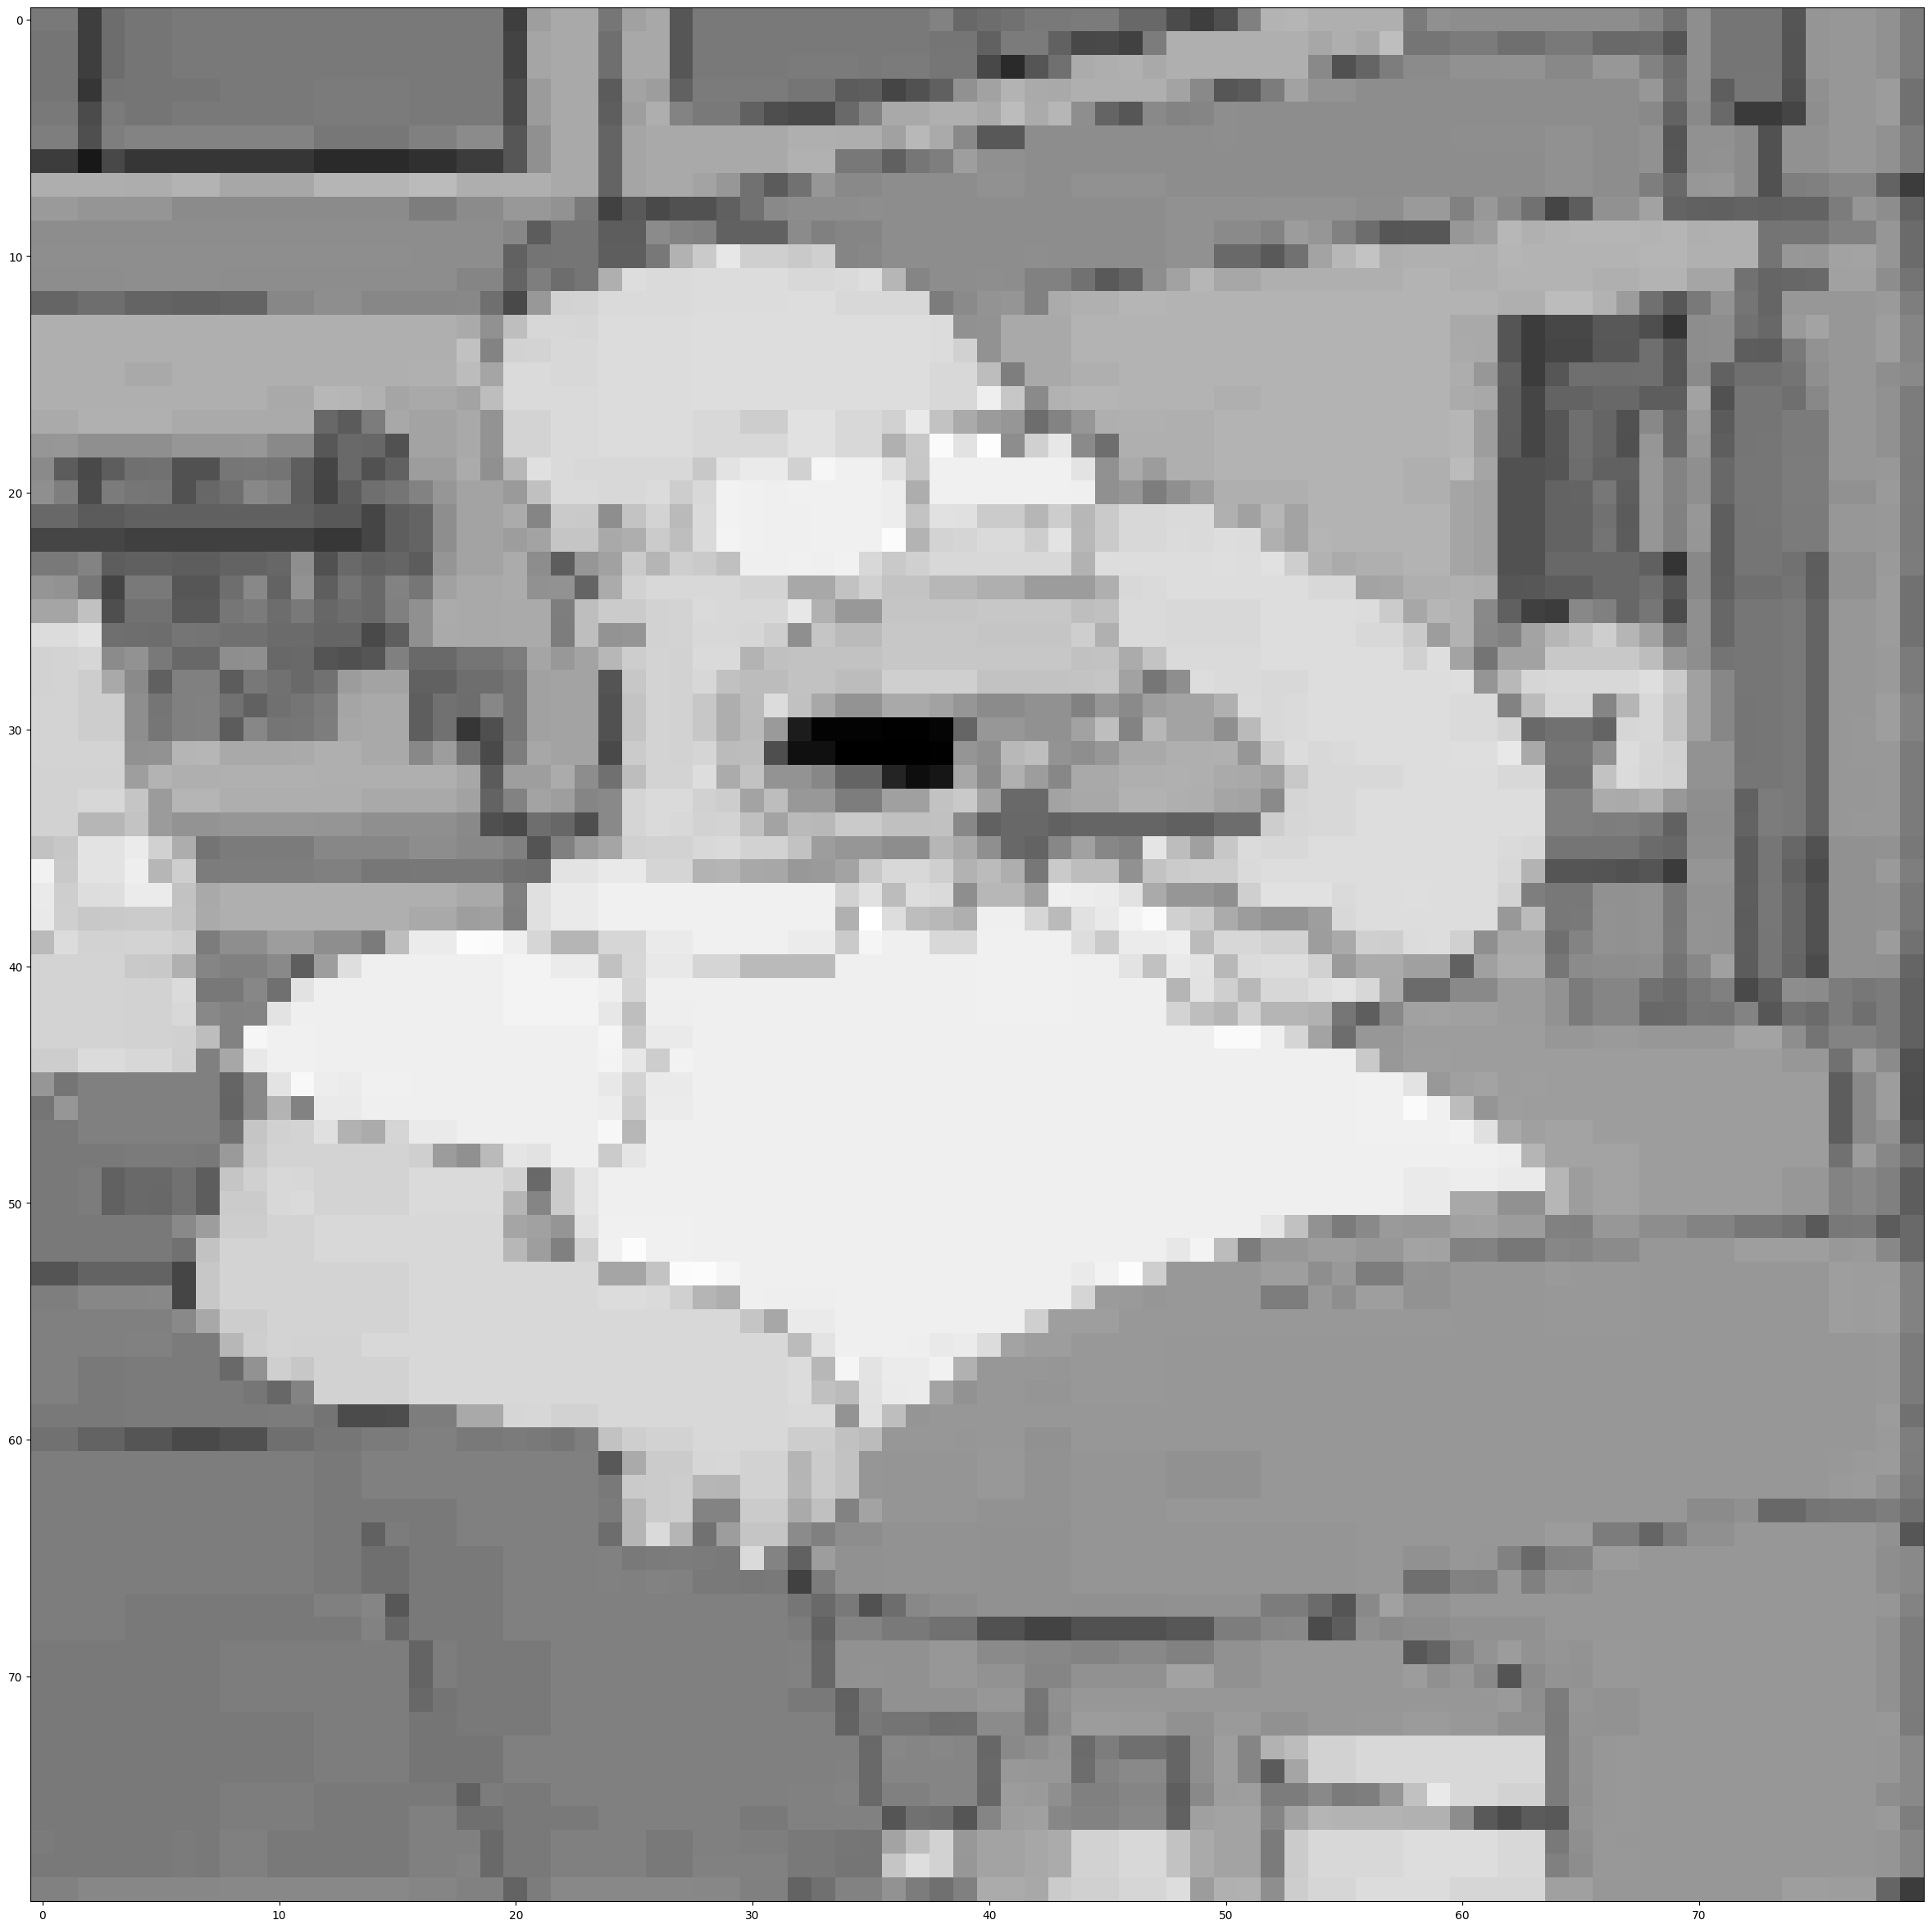

In [43]:
# Visualizing the data (OpenCV doesn't display well in Jupyter notebooks)
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [44]:
# Separating the array and corresponding labels
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [45]:
from tensorflow.keras.utils import to_categorical

# Normalize the featureSet ==> (0,1)
featureSet = caer.normalize(featureSet)
# Converting numerical labels to binary class vectors
labels = to_categorical(labels, len(characters))

In [47]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)

In [48]:
del train
del featureSet
del labels 
gc.collect()

0

In [62]:
BATCH_SIZE = 32
EPOCHS = 100

In [50]:
# Image data generator (introduces randomness in network ==> better accuracy)
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [58]:
# Create the model
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()

#Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output to feed into dense layers
model.add(layers.Flatten())

#Dense layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='sigmoid'))  # Using sigmoid for binary classification

#Compile the model
learning_rate = 0.001
momentum = 0.9
nesterov = True
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 78, 78, 32)        320       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 39, 39, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 18, 18, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 8, 8, 128)        

In [60]:
from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]

In [63]:
training = model.fit(train_gen, steps_per_epoch=len(x_train)//BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val), validation_steps=len(y_val)//BATCH_SIZE, callbacks=callbacks_list)

Epoch 1/100
345/345 [==============================] - 9s 25ms/step - loss: 0.2871 - accuracy: 0.3247 - val_loss: 0.2814 - val_accuracy: 0.3618 - lr: 0.0100
Epoch 2/100
345/345 [==============================] - 8s 23ms/step - loss: 0.2826 - accuracy: 0.3409 - lr: 0.0100
Epoch 3/100
345/345 [==============================] - 8s 23ms/step - loss: 0.2790 - accuracy: 0.3559 - lr: 0.0100
Epoch 4/100
345/345 [==============================] - 8s 24ms/step - loss: 0.2753 - accuracy: 0.3702 - lr: 0.0100
Epoch 5/100
345/345 [==============================] - 8s 23ms/step - loss: 0.2715 - accuracy: 0.3816 - lr: 0.0100
Epoch 6/100
345/345 [==============================] - 8s 23ms/step - loss: 0.2690 - accuracy: 0.3906 - lr: 0.0100
Epoch 7/100
345/345 [==============================] - 8s 24ms/step - loss: 0.2667 - accuracy: 0.3986 - lr: 0.0100
Epoch 8/100
345/345 [==============================] - 8s 24ms/step - loss: 0.2624 - accuracy: 0.4093 - lr: 0.0100
Epoch 9/100
345/345 [=================

In [64]:
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

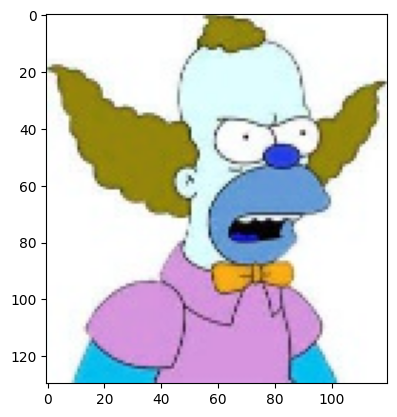

In [76]:
test_path = r'/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/krusty_the_clown_11.jpg'
img = cv.imread(test_path)

plt.imshow(img)
plt.show()

In [77]:
def prepare(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.resize(img, IMG_SIZE)
    img = caer.reshape(img, IMG_SIZE, 1)
    return img

In [78]:
predictions = model.predict(prepare(img))

1/1 [==============================] - 0s 21ms/step


In [79]:
print(characters[np.argmax(predictions[0])])

krusty_the_clown
